$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=30$

Use all datas 

# Create Environment

In [26]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=20

global M
M=10

global T
global target
T=5
target=np.array([0])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=2

global beta
beta=[-1,-0.5,0.5,1]

global num_system
num_system=4


global coeff
coeff=[1 for i in range(N+1)]

In [27]:
def Z(vecs, u):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        output.append([beta[i]*x+u])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [28]:
def next_step(vecs,action):  
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,action)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    var_x=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        var_x+=vecs[i][0]**2
    var_x=var_x-mu_x**2/num_system
    
    w=np.array([mu_x,var_x])/num_system

    return w

def reward(obs):
    return max(6-(obs[0]-target[0])**2-obs[1],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i]-target)
    return r

def value_func(funcs,next_state):
    x_cand = generate_cand(next_state)
    candidates_u, std_u = funcs.predict(x_cand.reshape(-1,obs_para+1), return_std=True)
    result=np.max(candidates_u)
    return result

# Learning Settings

In [29]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=5
global precision
precision=0.01
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)

def generate_cand(state):
    possible=np.linspace(-max_u, max_u,  int(2*max_u/precision+1))
    cand=[]
    for i in range( int(2*max_u/precision+1)):
        cand.append(np.concatenate((state,np.array([possible[i]]))))
    return np.array(cand)

def decide_u(funcs,state,init=False):
    explo=exploration()
    if init or explo:
        result=np.random.randint(int(2*max_u/precision+1))
        return np.linspace(-max_u, max_u,  int(2*max_u/precision+1))[result]
    else:
        x_cand = generate_cand(state)
        candidates_u, std_u = funcs.predict(x_cand.reshape(-1,obs_para+1), return_std=True)
        result=np.argmax(candidates_u)
    return np.linspace(-max_u, max_u,  int(2*max_u/precision+1))[result]
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para+1), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[]
history_r=[]
history_su_next=[]
#flags=[True for i in range(6)]

history_rt=[[] for j in range(N+1)]
history_sut=[[] for j in range(N+1)]
#flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [30]:
num_iter=20

position_result=[]
observation_result=[]
gpr_list=[0 for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[2] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr==0:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],observation,init=True)
            position_new = next_step(position,u_k)
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            
            if time==0:
                history_su = np.concatenate((observation,np.array([u_k]))).reshape(-1,obs_para+1)
                history_su_next = np.array(observation_new).reshape(-1,obs_para)
                history_r = np.array([r])
            
            
            else:
                obs_su=np.concatenate((observation,np.array([u_k])))
                history_su = np.concatenate((history_su, obs_su.reshape(-1,obs_para+1)))
                history_su_next = np.concatenate((history_su_next, observation_new.reshape(-1,obs_para)))
                history_r = np.concatenate((history_r,np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,u_k)
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            
            obs_su=np.concatenate((observation,np.array([u_k])))
            
            
            history_su = np.concatenate((history_su, obs_su.reshape(-1,obs_para+1)))
            history_su_next = np.concatenate((history_su_next, observation_new.reshape(-1,obs_para)))
            history_r = np.concatenate((history_r,np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
       
    for i in range(N+1):
        if i==1:
            history_target=coeff[-1]*history_r
            gpr_list[-i]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su).reshape(-1,obs_para+1), history_target.reshape(-1,1))
            
        elif i>1:
            history_tar=[]
            for k in range(history_r.shape[0]):
                history_tar.append(coeff[N+1-i]*history_r[k]+value_func(gpr_list[-i+1],history_su_next[k]))
            gpr_list[-i]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su).reshape(-1,obs_para+1), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    
    history_tar=[]
    for k in range(history_r.shape[0]):
        history_tar.append(coeff[0]*history_r[k]+value_func(gpr_list[1],history_su_next[k]))
    gpr_list[0]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su).reshape(-1,obs_para+1), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  5%|████▏                                                                              | 1/20 [00:02<00:40,  2.11s/it]

observation = [   63.7112248 10184.8840071]


 10%|████████▎                                                                          | 2/20 [00:06<01:00,  3.34s/it]

observation = [  45.86082871 7273.29726318]


 15%|████████████▍                                                                      | 3/20 [00:13<01:27,  5.12s/it]

observation = [  37.36714325 4752.13497481]


 20%|████████████████▌                                                                  | 4/20 [00:25<02:03,  7.69s/it]

observation = [  20.53639631 2457.42549413]


 25%|████████████████████▊                                                              | 5/20 [00:42<02:45, 11.01s/it]

observation = [-20.43635972 466.70492343]


 30%|████████████████████████▉                                                          | 6/20 [01:05<03:33, 15.27s/it]

observation = [-18.77390478 421.32720398]


 35%|█████████████████████████████                                                      | 7/20 [01:41<04:45, 21.99s/it]

observation = [  3.56695311 140.66914981]


 40%|█████████████████████████████████▏                                                 | 8/20 [02:25<05:47, 28.94s/it]

observation = [-8.91025657 50.61863374]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:19<06:46, 36.93s/it]

observation = [   85.5536925  22141.33273237]


 50%|█████████████████████████████████████████                                         | 10/20 [04:24<07:36, 45.61s/it]

observation = [  43.92610301 6010.31696481]


 55%|█████████████████████████████████████████████                                     | 11/20 [05:44<08:25, 56.16s/it]

observation = [ -58.51437847 5415.32224139]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:19<09:03, 67.92s/it]

observation = [  33.26932008 3960.79683464]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [09:18<09:42, 83.21s/it]

observation = [  39.89378035 5128.29683579]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [11:33<09:52, 98.83s/it]

observation = [   61.29657512 13884.64093007]


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [14:08<09:40, 116.04s/it]

observation = [ -32.99616195 1469.05565586]


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [17:06<08:57, 134.43s/it]

observation = [ 0.87152318 40.14520361]


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [20:24<07:40, 153.67s/it]

observation = [-18.50986354 389.92284736]


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [24:26<06:00, 180.33s/it]

observation = [  1.59531132 122.50302716]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:33<03:38, 218.41s/it]

observation = [-2.25816663  7.2860914 ]


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [36:53<00:00, 110.68s/it]

observation = [   68.72671805 15730.50256321]


# Results

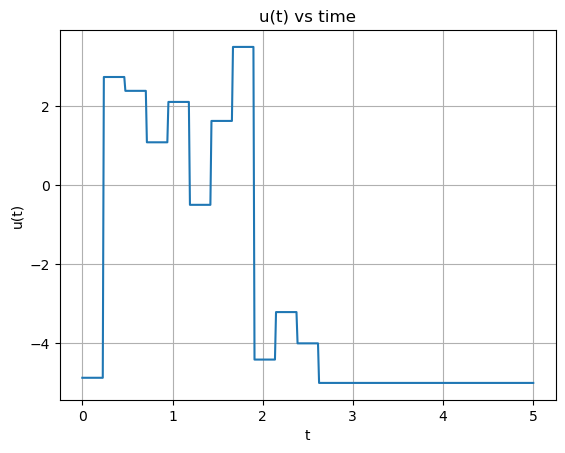

'\nx = np.linspace(0, T, (N+1)*20)\nplt.plot(x, v)\nplt.xlabel(\'t\')\nplt.ylabel(\'v(t)\')\nplt.title("v(t) vs time")\nplt.grid()\nplt.show()\n'

In [31]:
'''
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
'''     

us=[]
for i in range(len(u_t)):
    for j in range(20):
        us.append(u_t[i])


x = np.linspace(0, T, (N+1)*20)
plt.plot(x, us)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

'''
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()
'''

## Last Trajectory


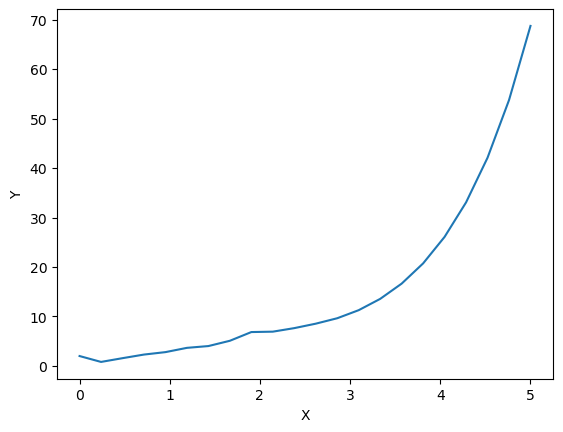

In [32]:
obs=np.array(observation_t)
x = np.linspace(0, T, N+2)
obs=obs[:,[0,1]]
plt.plot(x,obs[:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

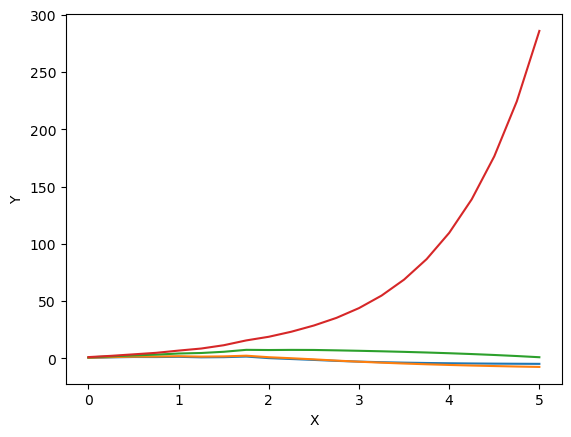

299.06259215104996


"\nplt.plot(np.array(cord_x),np.array(cord_y), 'o')\nplt.plot(np.array([3]),np.array([2]), 'o')\n#plt.plot(obs[-1,0],obs[-1,1])\nplt.xlabel('X')\nplt.ylabel('Y')\nplt.grid()\nplt.show()\n"

In [33]:
pos=[]
x = np.linspace(0, T, N+1)
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0]]
    plt.plot(x,obs[:,0])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    
'''
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()
'''


## Best Trajectory

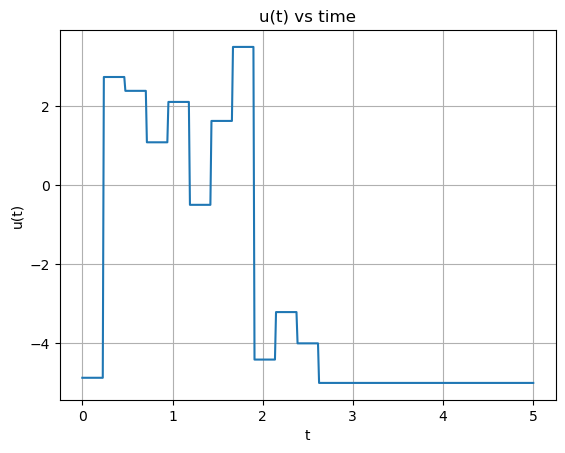

'\nx = np.linspace(0, T, (N+1)*20)\nplt.plot(x, v)\nplt.xlabel(\'t\')\nplt.ylabel(\'v(t)\')\nplt.title("v(t) vs time")\nplt.grid()\nplt.show()\n'

In [34]:
'''
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
'''
us=[]
for i in range(len(best_u)):
    for j in range(20):
        us.append(u_t[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, us)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

'''
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()
'''

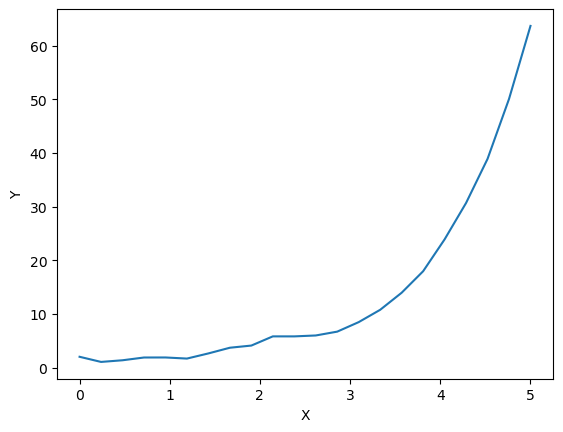

In [35]:
x = np.linspace(0, T, N+2)
obs=np.array(best_obs)
obs=obs[:,[0]]
plt.plot(x,obs[:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

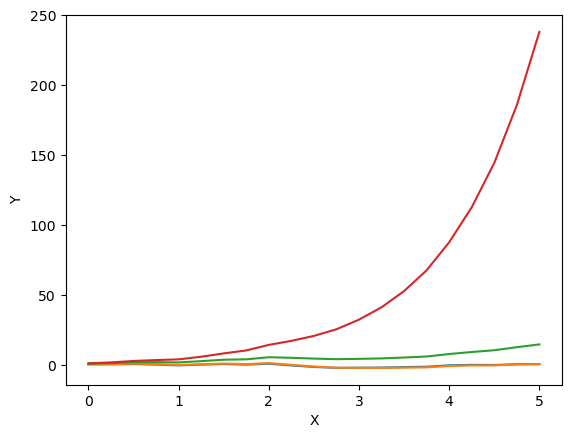

254.84489920050268


"\nplt.plot(np.array(cord_x),np.array(cord_y), 'o')\nplt.plot(np.array([3]),np.array([2]), 'o')\n#plt.plot(obs[-1,0],obs[-1,1])\nplt.xlabel('X')\nplt.ylabel('Y')\nplt.grid()\nplt.show()\n"

In [36]:
pos=[]
x = np.linspace(0, T, N+1)
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0]]
    plt.plot(x,obs[:,0])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])

'''
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()
'''

## Pure Exploitation Trajectory

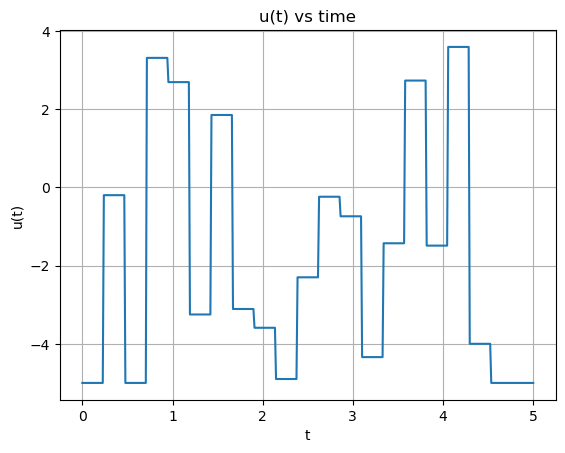

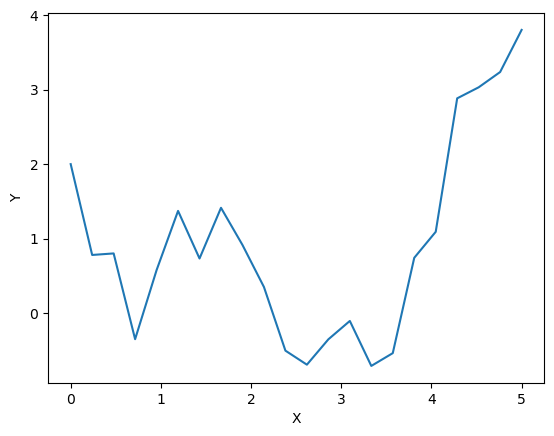

In [40]:
position=np.array([[2] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u(gpr_list[time],observation)
    position_new = next_step(position,u_k)
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    

us=[]

for i in range(len(u_t)):
    for j in range(20):
        us.append(u_t[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, us)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+2)
obs=np.array(observation_t)
obs=obs[:,[0]]
plt.plot(x,obs[:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

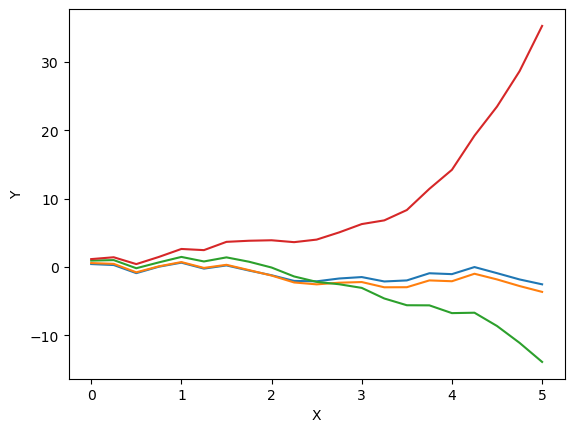

55.27664378904193


"\nplt.plot(np.array(cord_x),np.array(cord_y), 'o')\nplt.plot(np.array([3]),np.array([2]), 'o')\n#plt.plot(obs[-1,0],obs[-1,1])\nplt.xlabel('X')\nplt.ylabel('Y')\nplt.grid()\nplt.show()\n"

In [41]:
pos=[]
x = np.linspace(0, T, N+1)
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0]]
    plt.plot(x,obs[:,0])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
for i in range(num_system):
    cord_x.append(pos[i][0])

'''
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()
'''